In [1]:
import timeit
import torch
import torch.nn as nn

import random
import scipy.io
import numpy as np
from pyDOE import lhs
import matplotlib as mpl
import matplotlib.pyplot as plt
from torch.optim import lr_scheduler
from collections import OrderedDict

from math import exp


if torch.cuda.is_available():
    """ Cuda support """
    print('cuda available')
    device = torch.device('cuda')
else:
    print('cuda not avail')
    device = torch.device('cpu')
# device = torch.device('cpu')    
np.random.seed(1234)

def grad(u, x):
    """ Get grad """
    gradient = torch.autograd.grad(
        u, x,
        grad_outputs=torch.ones_like(u),
        retain_graph=True,
        create_graph=True
    )[0]
    return gradient


cuda available


shape of x (50, 1)
shape of u (50, 1)


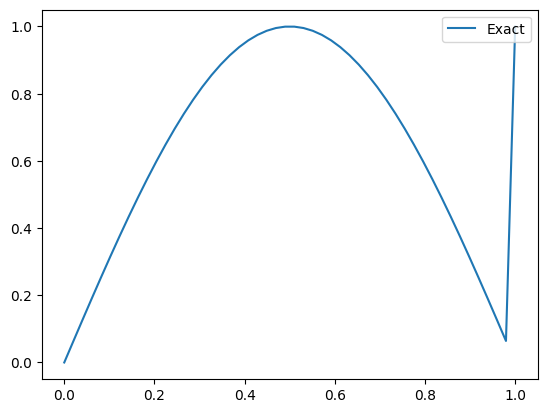

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from pyDOE import lhs

epochs = 100001

Diff = 1 * 1e-3

nPt = 50
x0 = 0.
x1 = 1.

x_in = np.linspace(x0, x1, nPt).reshape(-1, 1)

N_b = 50
N_f = 1000

lb = np.array([0.0])
ub = np.array([1.0])

X_f = lb + (ub - lb) * lhs(1, N_f)

def u(x):
    return np.sin(np.pi * x) + ((1 - np.exp(-x / Diff)) * np.exp((x-1) / Diff)) / (1 - np.exp(-1 / Diff)) 

idx_x = np.random.choice(x_in.shape[0], N_b, replace=True)
xb = x_in[idx_x,:]

X_lb = 0 * xb + lb[0]
X_ub = 0 * xb + ub[0]

u_in = u(x_in)

print('shape of x',x_in.shape)
print('shape of u',u_in.shape)

X_star = np.linspace(0, 1, nPt).reshape(-1, 1)
u_star = u(X_star)

plt.plot(X_star, u_star, label='Exact')
plt.legend(loc='upper right')
plt.show()

In [3]:
class MNISTChebyKAN(nn.Module):
    def __init__(self):
        super(MNISTChebyKAN, self).__init__()
        self.chebykan1 = ChebyKANLayer(28*28, 32, 4)
        self.ln1 = nn.LayerNorm(32) # To avoid gradient vanishing caused by tanh
        self.chebykan2 = ChebyKANLayer(32, 16, 4)
        self.ln2 = nn.LayerNorm(16)
        self.chebykan3 = ChebyKANLayer(16, 10, 4)

    def forward(self, x):
        x = x.view(-1, 28*28)  # Flatten the images
        x = self.chebykan1(x)
        x = self.ln1(x)
        x = self.chebykan2(x)
        x = self.ln2(x)
        x = self.chebykan3(x)
        return x
    
class GKNN1(torch.nn.Module):
    """ DNN Class """
    
    def __init__(self):
        super(GKNN1, self).__init__()
        self.net1 = nn.Sequential(nn.Linear(1, 100), nn.Sigmoid(),
                                 nn.Linear(100, 100), nn.Sigmoid(),
                                 nn.Linear(100, 100), nn.Sigmoid(),
                                 nn.Linear(100, 1))
    
    def forward(self, x):
        return self.net1(x)  


class GKNN2(torch.nn.Module):
    """ DNN Class """
    
    def __init__(self):
        super(GKNN2, self).__init__()
        self.net1 = nn.Sequential(nn.Linear(1, 100), nn.Sigmoid(),
                                 nn.Linear(100, 100), nn.Sigmoid(),
                                 nn.Linear(100, 100), nn.Sigmoid(),
                                 nn.Linear(100, 1))
        
        self.net2 = nn.Sequential(nn.Linear(1, 100), nn.Sigmoid(),
                                  nn.Linear(100, 100), nn.Sigmoid(),
                                  nn.Linear(100, 1))
        
        self.net3 = nn.Sequential(nn.Linear(1, 100), nn.Sigmoid(),
                                  nn.Linear(100, 100), nn.Sigmoid(),
                                  nn.Linear(100, 1))
        
    def forward(self, x):
        # a = torch.ones(nPt, 1).to(device)
        return self.net3(x)

In [4]:
class PINN():
    def __init__(self, X_f, X_lb, X_ub, epochs, Diff, X_star, u_star):
        
        self.rba = 1
        if self.rba == 1:
            self.rsum = 0
            self.eta = 0.001
            self.gamma = 0.999
        self.epochs = epochs
        self.Diff = Diff
        
        self.best_model_params = []
        self.min_l2_error = float('inf')
        
        self.X_star = X_star
        self.u_star = u_star
        
        self.iter = 0
        self.exec_time = 0
        
        self.x_f = torch.tensor(X_f, dtype=torch.float32, requires_grad=True).to(device)
        
        self.x_lb = torch.tensor(X_lb, dtype=torch.float32, requires_grad=True).to(device)
        self.x_ub = torch.tensor(X_ub, dtype=torch.float32, requires_grad=True).to(device)
        
        self.gknn1 = GKNN1().to(device)
        
        self.it = []; self.l2 = []; self.loss_u = []; self.loss_r = []; self.losses = []; self.lx = []
        
        self.optimizer1 = torch.optim.Adam(self.gknn1.parameters(), lr=1e-3, betas=(0.9, 0.999))
        
    def net_u(self, x):
        # a = torch.ones(nPt, 1).to(device) 
        u = self.gknn1(x)
        return u
    
    def net_r(self, x):
        u = self.net_u(x)
        
        u_x = grad(u, x)
        u_xx = grad(u_x, x)
        r = - self.Diff * u_xx + u_x - self.Diff * (torch.pi ** 2) * torch.sin(torch.pi * x) - torch.pi * torch.cos(torch.pi * x)
        return r
    
    
    def train(self):
        self.gknn1.train()
        
        a = timeit.default_timer()
        for epoch in range(self.epochs):
            start_time = timeit.default_timer()
            u_lb_pred = self.net_u(self.x_lb)
            u_ub_pred = self.net_u(self.x_ub)
            loss_u = torch.mean((u_lb_pred - 0) ** 2) + \
                     torch.mean((u_ub_pred - 1) ** 2)
            
            r_pred = self.net_r(self.x_f)
            
            loss_r = torch.mean(r_pred ** 2)
            
            r_norm = self.eta * torch.abs(r_pred) / torch.max(torch.abs(r_pred))
            self.rsum = (self.rsum * self.gamma + r_norm).detach()
            loss_r = torch.mean((r_pred) ** 2)
            loss = loss_u + loss_r 
            
            self.optimizer1.zero_grad()
            loss.backward()
            self.optimizer1.step()
            
            end_time = timeit.default_timer()
            self.exec_time = end_time - start_time
            
            if epoch % 100 ==0:
                u_pred = self.predict(self.X_star)
                l2_error = np.linalg.norm(self.u_star - u_pred, 2) / np.linalg.norm(self.u_star, 2)
                if l2_error < self.min_l2_error:
                    self.min_l2_error = l2_error
                    self.best_u_pred = u_pred
                
                self.loss_u.append(loss_u.item())
                self.loss_r.append(loss_r.item())
                self.losses.append(loss.item())
                self.l2.append(l2_error)
                
                print('It %d, Loss %.3e, min_Loss %.3e, l2_error %.3e, min_l2 %.3e, Time %.2f s' % (epoch, loss.item(), min(self.losses), l2_error, min(self.l2), self.exec_time))
                
                # if loss.item() < 5 * 1e-7:
                #     b = timeit.default_timer() - a
                #     print('Time for stop epochs %.2f s' % (b))
                #     break
                if epoch % 100000 ==0:
                    b = timeit.default_timer() - a
                    print('Time for 100000 epochs %.2f s' % (b))
                    
    def predict(self, X):
        x = torch.tensor(X, dtype=torch.float32, requires_grad=True).to(device)
        
        self.gknn1.eval()
        
        u = self.net_u(x)
        u = u.detach().cpu().numpy()
        return u        
    
    def get_best_u_pred(self):
        return self.best_u_pred



        

class RBAGKPINN():
    def __init__(self, X_f, X_lb, X_ub, epochs, Diff, X_star, u_star):
        
        self.rba = 1
        if self.rba == 1:
            self.rsum = 0
            self.eta = 0.001
            self.gamma = 0.999
        self.epochs = epochs
        self.Diff = Diff
        
        self.best_model_params = []
        self.min_l2_error = float('inf')
        
        self.X_star = X_star
        self.u_star = u_star
        
        self.iter = 0
        self.exec_time = 0
        
        self.x_f = torch.tensor(X_f, dtype=torch.float32, requires_grad=True).to(device)
        
        self.x_lb = torch.tensor(X_lb, dtype=torch.float32, requires_grad=True).to(device)
        self.x_ub = torch.tensor(X_ub, dtype=torch.float32, requires_grad=True).to(device)
        
        self.gknn1 = GKNN1().to(device)
        self.gknn2 = GKNN2().to(device)
        
        self.it = []; self.l2 = []; self.loss_u = []; self.loss_r = []; self.losses = []; self.lx = []
        
        self.optimizer1 = torch.optim.Adam(self.gknn1.parameters(), lr=1e-3, betas=(0.9, 0.999))
        self.optimizer2 = torch.optim.Adam(self.gknn2.parameters(), lr=1e-3, betas=(0.9, 0.999))
        
    def net_u(self, x):
        # a = torch.ones(nPt, 1).to(device) 
        u = self.gknn1(x) + self.gknn2(x) * torch.exp((x - 1) / self.Diff)
        return u
    
    def net_r(self, x):
        u = self.net_u(x)
        
        u_x = grad(u, x)
        u_xx = grad(u_x, x)
        r = - self.Diff * u_xx + u_x - self.Diff * (torch.pi ** 2) * torch.sin(torch.pi * x) - torch.pi * torch.cos(torch.pi * x)
        return r
    
    
    def train(self):
        self.gknn1.train()
        self.gknn2.train()
        
        a = timeit.default_timer()
        for epoch in range(self.epochs):
            start_time = timeit.default_timer()
            u_lb_pred = self.net_u(self.x_lb)
            u_ub_pred = self.net_u(self.x_ub)
            loss_u = torch.mean((u_lb_pred - 0) ** 2) + \
                     torch.mean((u_ub_pred - 1) ** 2)
            
            r_pred = self.net_r(self.x_f)
            
            # loss_r = torch.mean(r_pred ** 2)
            
            r_norm = self.eta * torch.abs(r_pred) / torch.max(torch.abs(r_pred))
            self.rsum = (self.rsum * self.gamma + r_norm).detach()
            loss_r = torch.mean((self.rsum * r_pred) ** 2)
            loss = loss_u + loss_r 
            
            self.optimizer1.zero_grad()
            self.optimizer2.zero_grad()
            loss.backward()
            self.optimizer1.step()
            self.optimizer2.step()
            
            end_time = timeit.default_timer()
            self.exec_time = end_time - start_time
            
            if epoch % 100 ==0:
                u_pred = self.predict(self.X_star)
                l2_error = np.linalg.norm(self.u_star - u_pred, 2) / np.linalg.norm(self.u_star, 2)
                if l2_error < self.min_l2_error:
                    self.min_l2_error = l2_error
                    self.best_u_pred = u_pred
                
                self.loss_u.append(loss_u.item())
                self.loss_r.append(loss_r.item())
                self.losses.append(loss.item())
                self.l2.append(l2_error)
                
                print('It %d, Loss %.3e, min_Loss %.3e, l2_error %.3e, min_l2 %.3e, Time %.2f s' % (epoch, loss.item(), min(self.losses), l2_error, min(self.l2), self.exec_time))
                
                # if loss.item() < 5 * 1e-7:
                #     b = timeit.default_timer() - a
                #     print('Time for stop epochs %.2f s' % (b))
                #     break
                if epoch % 100000 == 0:
                    b = timeit.default_timer() - a
                    print('Time for 100000 epochs %.2f s' % (b))
                    
    def predict(self, X):
        x = torch.tensor(X, dtype=torch.float32, requires_grad=True).to(device)
        
        self.gknn1.eval()
        self.gknn2.eval()
        
        u = self.net_u(x)
        u = u.detach().cpu().numpy()
        return u        
    
    def get_best_u_pred(self):
        return self.best_u_pred

In [ ]:
#model = PINN(x_in, u_in, epochs, Diff)
#model = GKPINN(x_in, u_in, epochs, Diff)
model = RBAGKPINN(X_f, X_lb, X_ub, epochs, Diff, X_star, u_star)
model.train()

It 0, Loss 6.676e-01, min_Loss 6.676e-01, l2_error 6.291e-01, min_l2 6.291e-01, Time 9.31 s
Time for 100000 epochs 9.32 s
It 100, Loss 3.404e-02, min_Loss 3.404e-02, l2_error 9.795e-01, min_l2 6.291e-01, Time 0.02 s
It 200, Loss 1.222e-01, min_Loss 3.404e-02, l2_error 9.770e-01, min_l2 6.291e-01, Time 0.02 s
It 300, Loss 2.488e-01, min_Loss 3.404e-02, l2_error 9.748e-01, min_l2 6.291e-01, Time 0.01 s


In [7]:
a = model.loss_u.index(min(model.loss_u))
b = model.loss_r.index(min(model.loss_r))
a * 100, min(model.loss_u), b * 100, min(model.loss_r)

(10100, 1.4580350815585064e-15, 99400, 7.969323689849261e-08)

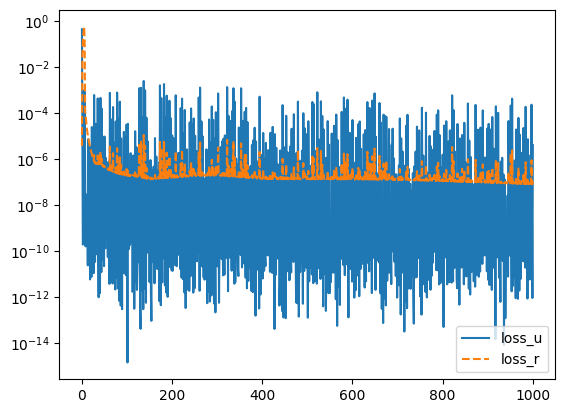

In [8]:
# fig = plt.figure(figsize=(12, 5))
# plt.subplot(1, 2, 1)
plt.plot(model.loss_u, label='loss_u')
plt.plot(model.loss_r, '--', label='loss_r')
plt.yscale('log')
plt.legend(loc='lower right')
plt.show()

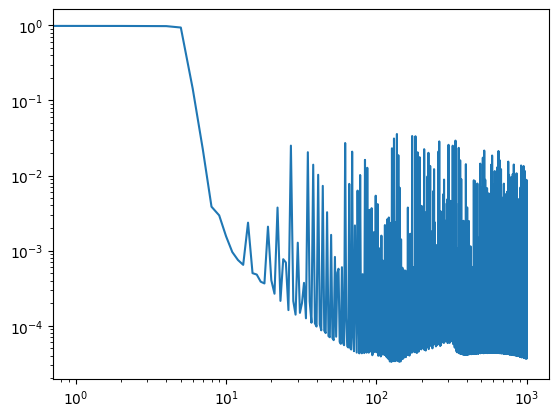

(126, '3.310e-05', '1.673e-07', '3.278e-11', '1.673e-07')

In [9]:
plt.plot(model.l2)
plt.xscale('log')
plt.yscale('log')
plt.show()
c = model.l2.index(min(model.l2))
c, "{:.3e}".format(min(model.l2)), "{:.3e}".format(model.losses[c]), "{:.3e}".format(model.loss_u[c]), "{:.3e}".format(model.loss_r[c])

l2_error: 3.309834e-05


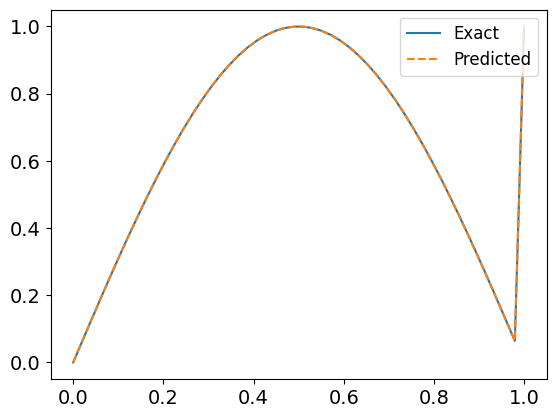

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

def u(x):
    return np.sin(np.pi * x) + ((1 - np.exp(-x / Diff)) * np.exp((x-1) / Diff)) / (1 - np.exp(-1 / Diff)) 

X_star = np.linspace(0, 1, nPt).reshape(-1, 1)

u_pred = model.get_best_u_pred()
# u_pred = model.predict(X_star)
u_star = u(X_star)

l2_error = np.linalg.norm(u_star - u_pred, 2) / np.linalg.norm(u_star, 2)
print('l2_error: %e' % (l2_error))

plt.tick_params(axis='both', which='major', labelsize=14)
plt.plot(X_star, u_star, label='Exact')
plt.plot(X_star, u_pred, '--',label='Predicted')
plt.legend(loc='upper right', fontsize='large')
plt.show()

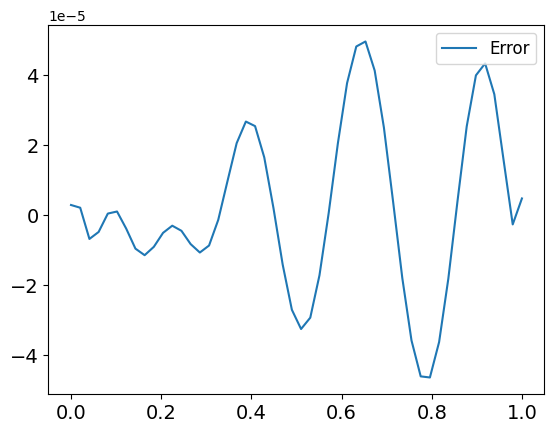

In [11]:
error_u = u_star - u_pred

plt.tick_params(axis='both', which='major', labelsize=14)
plt.plot(X_star, error_u, label='Error')
plt.legend(loc='upper right', fontsize='large')
plt.show()